<a href="https://colab.research.google.com/github/Feindrial/bondnet/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
import io
import re
import string
import tqdm
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split as sk_tt_split
import surprise as sp
from surprise.model_selection import cross_validate, train_test_split as sp_tt_split
from surprise import Dataset, Reader
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import LSTM
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import Input
from pathlib import Path
import matplotlib.pyplot as plt

In [90]:
print(tf.__version__)

locc = "LOCAL"

if locc == "LOCAL":

    #veri setinin indirilip dosya yollarının kaydedilmesi

    movielens_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

    downloaded_path = tf.keras.utils.get_file(movielens_url.rsplit('/').pop(), movielens_url, extract=True)

    dataset_dir = Path(downloaded_path).parent / Path(downloaded_path).stem
    print(dataset_dir)

    #indirelen veri setinin ilgili csv dosyaları pandas dataframe olarak atandı

elif locc == "COLAB":

    dataset_dir = Path("/content")
    print(dataset_dir)

    ! pip install -q kaggle
    from google.colab import files
    files.upload()

    ! mkdir ~/.kaggle
    ! mv kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json

    !kaggle datasets download "shubhammehta21/movie-lens-small-latest-dataset"
    !unzip -j "movie-lens-small-latest-dataset"

else:
    raise RuntimeError

2.12.0
C:\Users\feind\.keras\datasets\ml-latest-small


In [91]:
ratings_file = dataset_dir / "ratings.csv"
ratings = pd.read_csv(
    ratings_file
)
ratings["rating"] = ratings["rating"] * 2
ratings["rating"] = ratings["rating"].astype("int64")

movies_file = dataset_dir / "movies.csv"
movies = pd.read_csv(
    movies_file
)

In [92]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userId     100836 non-null  int64
 1   movieId    100836 non-null  int64
 2   rating     100836 non-null  int64
 3   timestamp  100836 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [93]:
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,8,964982703
1,1,3,8,964981247
2,1,6,8,964982224
3,1,47,10,964983815
4,1,50,10,964982931
5,1,70,6,964982400
6,1,101,10,964980868
7,1,110,8,964982176
8,1,151,10,964984041
9,1,157,10,964984100


In [94]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [95]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


<Axes: xlabel='rating'>

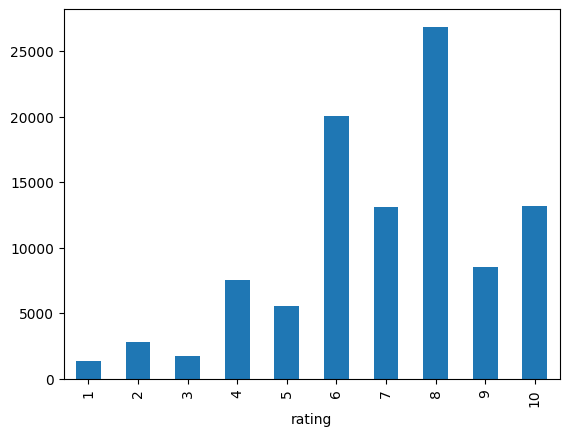

In [96]:
ratings["rating"].value_counts().sort_index().plot.bar()

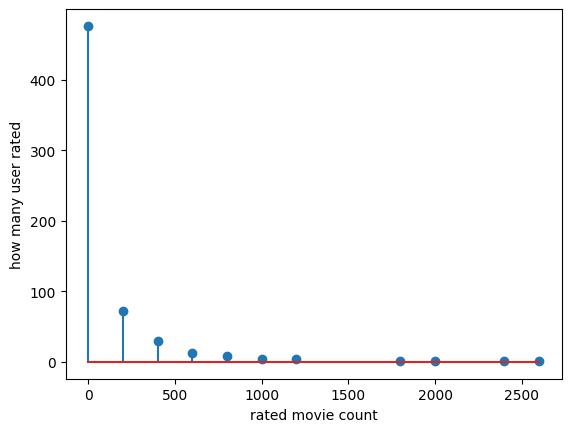

In [97]:
u200 = np.unique(ratings["userId"].value_counts().to_numpy() // 200 * 200, return_counts=True)

fig, ax = plt.subplots()
ax.stem(u200[0], u200[1])
ax.set_xlabel('rated movie count')
ax.set_ylabel('how many user rated')
plt.show()

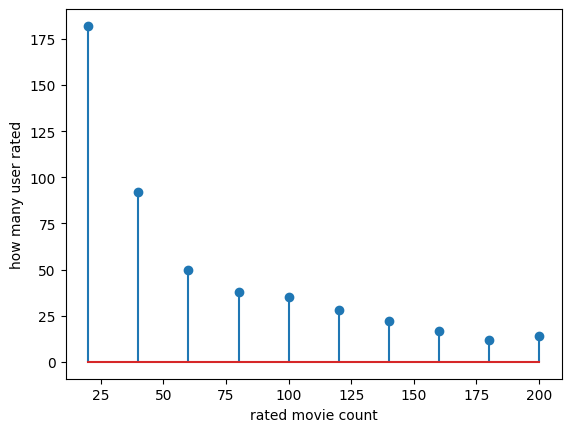

In [98]:
u20 = np.unique(ratings["userId"].value_counts().to_numpy() // 20 * 20, return_counts=True)
u20x = u20[0][:10]
u20y = u20[1][:10]
fig, ax = plt.subplots()
ax.stem(u20x, u20y)
ax.set_xlabel('rated movie count')
ax.set_ylabel('how many user rated')
plt.show()

<Axes: >

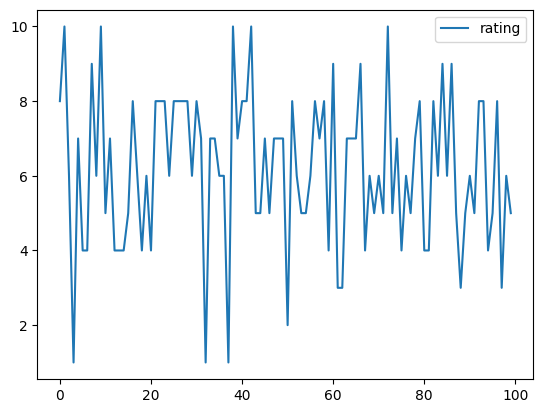

In [99]:
uidplt = ratings.iloc[np.random.randint(len(ratings))]["userId"]
uidrt = ratings[ratings["userId"] == uidplt].sort_values(by=["timestamp"])[["timestamp", "rating"]]
uidrt.set_index(np.arange(len(uidrt))).drop(["timestamp"], axis=1).iloc[:100].plot()

In [100]:
ratings["rating"].describe()

count    100836.000000
mean          7.003114
std           2.085058
min           1.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          10.000000
Name: rating, dtype: float64

In [101]:
ratings["userId"].value_counts().describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: count, dtype: float64

In [102]:
movies = movies.drop(["genres", "title"], axis=1)
movies.head(3)

,movieId
0,1
1,2
2,3


In [103]:
ratings = ratings.join(movies.set_index("movieId"), on="movieId", how="inner")
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,8,964982703
516,5,1,8,847434962
874,7,1,9,1106635946
1434,15,1,5,1510577970
1667,17,1,9,1305696483


In [104]:
ratings = ratings.sort_values(['userId', 'timestamp'], ascending=[True, True])
ratings.head(5)

,userId,movieId,rating,timestamp
43,1,804,8,964980499
73,1,1210,10,964980499
120,1,2018,10,964980523
171,1,2628,8,964980523
183,1,2826,8,964980523


In [105]:
ratings.rename(columns={"userId":"user_id", "movieId":"item_id"}, inplace=True)

In [106]:
train_size = 0.6
val_size = 0.2
test_size = 0.2

train_ratings = pd.DataFrame()
val_ratings = pd.DataFrame()
test_ratings = pd.DataFrame()

In [107]:
iround = 0
uniusers = ratings["user_id"].unique()
np.random.seed(1337)
np.random.shuffle(uniusers)

for user in uniusers:
    user_len = len(ratings[ratings["user_id"] == user])

    if iround == 3:
        iround = 0

    if iround == 0:
        train_start = 0
        train_end = int(user_len * train_size)

        val_start = int(user_len * train_size)
        val_end = int(user_len * (train_size + val_size))

        test_start = int(user_len * (train_size + val_size))
        test_end = int(user_len * (train_size + val_size + test_size))
    elif iround == 1:
        val_start = 0
        val_end = int(user_len * val_size)

        train_start = int(user_len * val_size)
        train_end = int(user_len * (train_size + val_size))

        test_start = int(user_len * (train_size + val_size))
        test_end = int(user_len * (train_size + val_size + test_size))
    elif iround == 2:
        val_start = 0
        val_end = int(user_len * val_size)

        test_start = int(user_len * val_size)
        test_end = int(user_len * (test_size + val_size))

        train_start = int(user_len * (test_size + val_size))
        train_end = int(user_len * (train_size + val_size + test_size))

    train_ratings = pd.concat([train_ratings, ratings[ratings["user_id"] == user].sort_values("timestamp").iloc[train_start:train_end]])
    val_ratings = pd.concat([val_ratings, ratings[ratings["user_id"] == user].sort_values("timestamp").iloc[val_start:val_end]])
    test_ratings = pd.concat([test_ratings, ratings[ratings["user_id"] == user].sort_values("timestamp").iloc[test_start:test_end]])

    iround += 1

In [108]:
from pathlib import Path  
trainpath = Path('./dataset/train.csv')
valpath = Path('./dataset/val.csv')
testpath = Path('./dataset/test.csv')

SAVE DATASET ACCORDING TO SPLIT

In [109]:
train_ratings.sort_values(["user_id", "timestamp"], ascending=[True, True]).to_csv(trainpath, index=False) 
val_ratings.sort_values(["user_id", "timestamp"], ascending=[True, True]).to_csv(valpath, index=False) 
test_ratings.sort_values(["user_id", "timestamp"], ascending=[True, True]).to_csv(testpath, index=False) 

LOAD SPLITTED DATASET

In [110]:
train_ratings = pd.read_csv(
    trainpath
)
val_ratings = pd.read_csv(
    valpath
)
test_ratings = pd.read_csv(
    testpath
)

In [111]:
train_ratings.tail()

,user_id,item_id,rating,timestamp
60488,610,39381,8,1493846973
60489,610,137857,8,1493846975
60490,610,103384,7,1493846980
60491,610,3948,8,1493847002
60492,610,3911,9,1493847010


In [112]:
val_ratings.tail()

,user_id,item_id,rating,timestamp
20013,610,27778,6,1493848667
20014,610,55067,7,1493848671
20015,610,103219,7,1493848674
20016,610,51666,4,1493848680
20017,610,112727,6,1493848682


In [113]:
test_ratings.tail()

,user_id,item_id,rating,timestamp
20320,610,101739,7,1495959269
20321,610,70,8,1495959282
20322,610,328,7,1495959299
20323,610,2459,7,1495959405
20324,610,3917,8,1495959411


In [166]:
vocab = {}
vocab['<pad>'] = 0
vocab['<unk>'] = 1
index = len(vocab)

utokens = train_ratings["user_id"].unique()
utokens = np.sort(utokens)
itokens = train_ratings["item_id"].unique()
itokens = np.sort(itokens)
rtokens = train_ratings["rating"].unique()
rtokens = np.sort(rtokens)

for t in utokens:    
    vocab[str(("u") + str(t))] = index
    index += 1

for t in itokens:    
    vocab[str(("i") + str(t))] = index
    index += 1

for t in rtokens:    
    vocab[str(("r") + str(t))] = index
    index += 1

print(vocab)

{'<pad>': 0, '<unk>': 1, 'u1': 2, 'u2': 3, 'u3': 4, 'u4': 5, 'u5': 6, 'u6': 7, 'u7': 8, 'u8': 9, 'u9': 10, 'u10': 11, 'u11': 12, 'u12': 13, 'u13': 14, 'u14': 15, 'u15': 16, 'u16': 17, 'u17': 18, 'u18': 19, 'u19': 20, 'u20': 21, 'u21': 22, 'u22': 23, 'u23': 24, 'u24': 25, 'u25': 26, 'u26': 27, 'u27': 28, 'u28': 29, 'u29': 30, 'u30': 31, 'u31': 32, 'u32': 33, 'u33': 34, 'u34': 35, 'u35': 36, 'u36': 37, 'u37': 38, 'u38': 39, 'u39': 40, 'u40': 41, 'u41': 42, 'u42': 43, 'u43': 44, 'u44': 45, 'u45': 46, 'u46': 47, 'u47': 48, 'u48': 49, 'u49': 50, 'u50': 51, 'u51': 52, 'u52': 53, 'u53': 54, 'u54': 55, 'u55': 56, 'u56': 57, 'u57': 58, 'u58': 59, 'u59': 60, 'u60': 61, 'u61': 62, 'u62': 63, 'u63': 64, 'u64': 65, 'u65': 66, 'u66': 67, 'u67': 68, 'u68': 69, 'u69': 70, 'u70': 71, 'u71': 72, 'u72': 73, 'u73': 74, 'u74': 75, 'u75': 76, 'u76': 77, 'u77': 78, 'u78': 79, 'u79': 80, 'u80': 81, 'u81': 82, 'u82': 83, 'u83': 84, 'u84': 85, 'u85': 86, 'u86': 87, 'u87': 88, 'u88': 89, 'u89': 90, 'u90': 91, 'u

In [167]:
inverse_vocab = {index: token for token, index in vocab.items()}

print(inverse_vocab)

{0: '<pad>', 1: '<unk>', 2: 'u1', 3: 'u2', 4: 'u3', 5: 'u4', 6: 'u5', 7: 'u6', 8: 'u7', 9: 'u8', 10: 'u9', 11: 'u10', 12: 'u11', 13: 'u12', 14: 'u13', 15: 'u14', 16: 'u15', 17: 'u16', 18: 'u17', 19: 'u18', 20: 'u19', 21: 'u20', 22: 'u21', 23: 'u22', 24: 'u23', 25: 'u24', 26: 'u25', 27: 'u26', 28: 'u27', 29: 'u28', 30: 'u29', 31: 'u30', 32: 'u31', 33: 'u32', 34: 'u33', 35: 'u34', 36: 'u35', 37: 'u36', 38: 'u37', 39: 'u38', 40: 'u39', 41: 'u40', 42: 'u41', 43: 'u42', 44: 'u43', 45: 'u44', 46: 'u45', 47: 'u46', 48: 'u47', 49: 'u48', 50: 'u49', 51: 'u50', 52: 'u51', 53: 'u52', 54: 'u53', 55: 'u54', 56: 'u55', 57: 'u56', 58: 'u57', 59: 'u58', 60: 'u59', 61: 'u60', 62: 'u61', 63: 'u62', 64: 'u63', 65: 'u64', 66: 'u65', 67: 'u66', 68: 'u67', 69: 'u68', 70: 'u69', 71: 'u70', 72: 'u71', 73: 'u72', 74: 'u73', 75: 'u74', 76: 'u75', 77: 'u76', 78: 'u77', 79: 'u78', 80: 'u79', 81: 'u80', 82: 'u81', 83: 'u82', 84: 'u83', 85: 'u84', 86: 'u85', 87: 'u86', 88: 'u87', 89: 'u88', 90: 'u89', 91: 'u90', 92

In [187]:
window_size = 6
vocab_size = len(vocab)
sequence_length = train_ratings["user_id"].value_counts().iloc[0]
batch_size = 1024
buffer_size = 10000
embedding_dim = 64

In [170]:
def get_bonds(sdf):
    bonds = []
    for user in sdf["user_id"].unique():
        abond = []
        for _, row in sdf[sdf["user_id"] == user][:-1].iterrows():
            ubond = str("u" + str(row["user_id"]))
            ibond = str("i" + str(row["item_id"]))
            rbond = str("r" + str(row["rating"]))
            abond.append(ubond)
            abond.append(ibond)
            abond.append(rbond)

        bonds.append(abond)
        abond = []

    return bonds

In [182]:
def get_bonds_enc(bonds):
    #bonds_enc = [vocab[token] if token in vocab else vocab['<unk>'] for bond in bonds for token in bond]
    bonds_enc = []
    for bond in bonds:
        mbond = []
        for token in bond:
            if token in vocab:
                mbond.append(vocab[token])
            else:
                mbond.append(vocab['<unk>'])
        bonds_enc.append(mbond)
        mbond = []

    bonds_enc = pad_sequences(bonds_enc, maxlen=sequence_length, padding='post', truncating='post', value=vocab['<pad>'])
    return bonds_enc

In [172]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  targets, contexts, labels = [], [], []

  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  for sequence in tqdm.tqdm(sequences):

    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [207]:
sequences = get_bonds_enc(get_bonds(train_ratings))
sequences

array([[   2, 2329, 8480, ...,    0,    0,    0],
       [   3, 4787, 8478, ...,    0,    0,    0],
       [   4, 4771, 8480, ...,    0,    0,    0],
       ...,
       [ 609, 3010, 8476, ...,    0,    0,    0],
       [ 610,  765, 8476, ...,    0,    0,    0],
       [ 611,  879, 8476, ..., 8476,  611, 4353]])

In [213]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=window_size,
    num_ns=4,
    vocab_size=vocab_size,
    seed=1337)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

100%|██████████| 610/610 [09:22<00:00,  1.09it/s]


In [214]:
from pathlib import Path
bondtargets_path = Path('./dataset/bond_targets.npy')
bondcontexts_path = Path('./dataset/bond_contexts.npy')
bondlabelss_path = Path('./dataset/bond_labels.npy')

SAVE BONDS

In [215]:
with open(bondtargets_path, 'wb') as f:
    np.save(f, targets, allow_pickle=True)
with open(bondcontexts_path, 'wb') as f:
    np.save(f, contexts, allow_pickle=True)
with open(bondlabelss_path, 'wb') as f:
    np.save(f, labels, allow_pickle=True)

LOAD BONDS

In [216]:
targets = None
contexts = None
labels = None

with open(bondtargets_path, 'rb') as f:
    targets = np.load(f, allow_pickle=True)
with open(bondcontexts_path, 'rb') as f:
    contexts = np.load(f, allow_pickle=True)
with open(bondlabelss_path, 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [218]:
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print(dataset)

<_PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [ ]:
class Bond2Vec(keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Bond2Vec, self).__init__()

        self.target_embedding = keras.layers.Embedding(vocab_size,
                                                 embedding_dim,
                                                 name="b2v_embedding")
        self.context_embedding = keras.layers.Embedding(vocab_size,
                                                  embedding_dim)

    def call(self, pair):
        target, context = pair
        
        if len(target.shape) == 2:
          target = tf.squeeze(target, axis=1)
        
        word_emb = self.target_embedding(target)    
        context_emb = self.context_embedding(context)        
        
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)        
        return dots

In [37]:
# class PreWarmUPBondnet(keras.Model):
#     def __init__(self, data: pd.DataFrame, cat_size, embedding_size=32, batch_size=32, saved_dataset=None, **kwds):
#         super(PreWarmUPBondnet, self).__init__(**kwds)

#         self.data = data
#         #DONT FORGET TO DELETE
#         self.data = self.data.sample(50)
#         print(self.data.nunique())

#         self.embedding_size = embedding_size
#         self.batch_size = batch_size
#         self.cat_size = cat_size


#         data_useritem_pivot = self.data.pivot(index="user_id", columns="item_id", values="rating").fillna(self.data['rating'].mean())
#         from sklearn.decomposition import non_negative_factorization
#         self.W, H, _ = non_negative_factorization(data_useritem_pivot, n_components=self.embedding_size, init='random')
#         self.H = H.T

#         self.inputs1 = keras.layers.Input(shape=(2), batch_size=None)
#         self.inputs2 = keras.layers.Input(shape=(1), batch_size=None)
#         self.rating_embed = keras.layers.Embedding(self.cat_size, self.embedding_size,
#                                                    embeddings_initializer="random_normal", embeddings_regularizer=keras.regularizers.L1L2(), name="RatingEmbed")
#         self.user_embed = keras.layers.Embedding(self.data["user_id"].nunique(), self.embedding_size, weights=[self.W],
#                                                  embeddings_initializer="random_normal", embeddings_regularizer=keras.regularizers.L1L2(l1=5e-4, l2=5e-4), name="UserEmbed")
#         self.item_embed = keras.layers.Embedding(self.data["item_id"].nunique(), self.embedding_size, weights=[self.H],
#                                                  embeddings_initializer="random_normal", embeddings_regularizer=keras.regularizers.L1L2(l1=5e-4, l2=1e-4), name="ItemEmbed")
        


#         self.pp_train = []
#         if saved_dataset is None:

#             userarr = np.sort(self.data["user_id"].unique())
#             itemarr = np.sort(self.data["item_id"].unique())

#             indices_iterator = np.ndindex(len(self.W), len(self.H), self.cat_size)
#             indices_arr = list(indices_iterator)
#             indices_choice = np.random.choice(len(indices_arr), len(indices_arr), replace=False)

#             print("Randoms are ready.")
            
#             ui_embed = []
#             rt_index = []
#             y = []
#             for c in indices_choice:

#                 user_index, item_index, rating_index = indices_arr[c]

#                 user_id = userarr[user_index]
#                 item_id = itemarr[item_index]

#                 # user_embed = self.W[user_index]
#                 # item_embed = self.H[item_index]
#                 # ui_embed.append(np.asanyarray([user_embed, item_embed]))
#                 ui_embed.append(np.asanyarray([user_index, item_index]))
#                 rt_index.append(np.asanyarray(rating_index))

#                 rating_value = (rating_index + 1) * 0.5
#                 if len(self.data[(self.data["user_id"] == user_id) & (self.data["item_id"] == item_id) & (self.data["rating"] == rating_value)]) == 0:
#                     y.append(np.asanyarray(0.0))
#                 else:
#                     y.append(np.asanyarray(1.0))

#                 if len(ui_embed) == self.batch_size:
#                     self.pp_train.append(((np.asanyarray(ui_embed), np.asanyarray(rt_index)), np.asanyarray(y)))
#                     ui_embed = []
#                     rt_index = []
#                     y = []

#             if len(ui_embed) != 0:
#                 self.pp_train.append(((np.asanyarray(ui_embed), np.asanyarray(rt_index)), np.asanyarray(y)))
#                 ui_embed = []
#                 rt_index = []
#                 y = []

#             with open("dataset/" + "E" + str(embedding_size) + "B" + str(batch_size) + "train_dataset.npy", 'wb') as f:
#                 np.save(f, self.pp_train, allow_pickle=True)
#         else:
#             with open(saved_dataset, 'rb') as f:
#                 self.pp_train = np.load(f, allow_pickle=True)


#     def train_spe(self):
#         return int(np.ceil((self.data["user_id"].nunique() * self.data["item_id"].nunique() * self.data["rating"].nunique()) / self.batch_size))

#     def __data_gen(self):        
#         pass
        

#     def get_dataset(self):
#         signature = ((tf.TensorSpec(shape=(None, 2), dtype=tf.int32),
#                       tf.TensorSpec(shape=(None,), dtype=tf.int32)),
#                       tf.TensorSpec(shape=(None,), dtype=tf.float32))

#         train_dataset = tf.data.Dataset.from_generator(
#             self.__data_gen,
#             output_signature=signature
#         )

#         return train_dataset

#     def call(self, inputs):
#         # user_vec = inputs[0][:, 0]
#         # item_vec = inputs[0][:, 1]



#         user_vec = self.user_embed(inputs[0][:, 0])
#         item_vec = self.item_embed(inputs[0][:, 1])
#         rating_indices = inputs[1]

#         rating_vec = self.rating_embed(rating_indices)

#         useritem = tf.reduce_sum(tf.multiply(user_vec, item_vec), 1)
#         userrating = tf.reduce_sum(tf.multiply(user_vec, rating_vec), 1)
#         itemrating = tf.reduce_sum(tf.multiply(item_vec, rating_vec), 1)



#         # ui_cross = (user_vec + item_vec) / 2
#         # return tf.reduce_sum(tf.multiply(rating_vec, ui_cross), 1)



#         return useritem * userrating * itemrating

In [52]:
b2v = Bond2Vec(vocab_size, embedding_dim)

user_id      44
item_id      49
rating       10
timestamp    50
dtype: int64
Randoms are ready.


c:\feindrial\py_env\Lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [53]:
with open("dataset/E1B1train_dataset.npy", 'rb') as f:
    asdasdasdsada = np.load(f, allow_pickle=True)

In [22]:
Xy_train = pwu_bondnet.get_dataset()

In [15]:
for Xy in Xy_train:
    print(Xy)
    break

((<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 443, 6153],
       [ 148, 3290]])>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 5])>), <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>)


In [23]:
pwu_bondnet.compile(
    loss="huber",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.MeanSquaredError(),
        keras.metrics.RootMeanSquaredError(),
    ]
)

In [24]:
model_checkpoint = ModelCheckpoint("./models/three_point.weights.h5", monitor="loss", mode="max", save_best_only=True, save_weights_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

pwu_history = pwu_bondnet.fit(
    Xy_train.repeat(),
    steps_per_epoch=pwu_bondnet.train_spe(),
    epochs=50,
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/50


AttributeError: in user code:

    File "c:\feindrial\py_env\Lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\feindrial\py_env\Lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\feindrial\py_env\Lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\feindrial\py_env\Lib\site-packages\keras\engine\training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\feindrial\py_env\Lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "c:\feindrial\py_env\Lib\site-packages\keras\engine\compile_utils.py", line 263, in __call__
        y_t, y_p, sw = match_dtype_and_rank(y_t, y_p, sw)
    File "c:\feindrial\py_env\Lib\site-packages\keras\engine\compile_utils.py", line 831, in match_dtype_and_rank
        if y_t.shape.rank == 1 and y_p.shape.rank == 2:

    AttributeError: 'float' object has no attribute 'shape'


In [254]:
pwu_bondnet.summary()

Model: "pre_warm_up_bondnet_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RatingEmbed (Embedding)     multiple                  320       
                                                                 
 UserEmbed (Embedding)       multiple                  1216      
                                                                 
 ItemEmbed (Embedding)       multiple                  19424     
                                                                 
Total params: 20,960
Trainable params: 20,960
Non-trainable params: 0
_________________________________________________________________


In [66]:
np.sort(pwu_bondnet.data["item_id"].unique())

array([     5,      6,     34,     95,    145,    161,    169,    173,
          186,    196,    253,    272,    276,    292,    293,    317,
          350,    367,    474,    500,    519,    531,    539,    541,
          707,    780,    786,    916,   1073,   1199,   1201,   1208,
         1222,   1288,   1375,   1387,   1454,   1527,   1584,   1587,
         1653,   2010,   2160,   2396,   2495,   2539,   2571,   2640,
         2944,   2987,   3210,   3260,   3408,   3418,   3549,   3698,
         3755,   3826,   3949,   3996,   4022,   4078,   4262,   4356,
         4368,   4378,   4643,   4888,   4973,   5932,   6373,   7153,
         7925,   8368,   8784,   8879,  26265,  30749,  33499,  33660,
        33836,  45732,  52973,  54272,  56949,  60979,  63072,  67087,
        67255,  80139,  91529,  94677,  98239,  99114, 101962, 107406,
       108932, 109487, 130490], dtype=int64)

In [67]:
np.sort(pwu_bondnet.data["user_id"].unique())

array([  1,  19,  27,  43,  50,  57,  64,  68,  89,  96, 103, 105, 111,
       117, 119, 122, 123, 125, 131, 136, 143, 144, 147, 171, 177, 182,
       190, 202, 204, 232, 239, 249, 274, 275, 287, 290, 298, 302, 305,
       307, 313, 316, 318, 325, 329, 332, 334, 339, 353, 354, 367, 373,
       381, 382, 387, 414, 417, 425, 438, 448, 474, 475, 477, 483, 489,
       490, 523, 524, 532, 541, 563, 567, 573, 586, 592, 600, 602, 603,
       606, 608], dtype=int64)

In [72]:
pwu_bondnet.data[(pwu_bondnet.data["user_id"] == 43)]

,user_id,item_id,rating,timestamp
6371,43,350,4.0,848993903
6330,43,95,4.0,848993983
6356,43,276,5.0,848994265


In [86]:
userrr_vec = pwu_bondnet.W[16]
itemmm_vec = pwu_bondnet.H[3]

In [87]:
tplmvecc = (userrr_vec + itemmm_vec) / 2
tplmvecc

array([1.11207162, 1.0547363 , 0.67871756, 0.76262731, 0.60208082])

In [88]:
tf.tensordot(tplmvecc.tolist(), [-2.4175814e-03,  8.8441151e-04, -9.0865273e-04,  1.7733764e-03, 2.6250796e-03], axes=1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00056051393>

In [81]:
tf.reduce_sum(tf.multiply(tplmvecc, [-2.4175814e-03,  8.8441151e-04, -9.0865273e-04,  1.7733764e-03, 2.6250796e-03]), )

InvalidArgumentError: {{function_node __wrapped__Sum_device_/job:localhost/replica:0/task:0/device:CPU:0}} Invalid reduction dimension (1 for input with 1 dimension(s) [Op:Sum]

In [61]:
pwu_bondnet.get_weights()

[array([[-1.8160141e-03, -2.7124295e-03,  2.8509665e-03, -5.9462531e-04,
          2.9892433e-03],
        [-1.4307820e-07,  1.6460662e-07, -3.9065185e-07,  4.6537545e-07,
         -2.1384253e-08],
        [-3.9853534e-05, -2.2242864e-05,  1.4934649e-05,  4.0467618e-05,
          2.2146003e-05],
        [ 1.8550756e-03, -1.5283744e-04,  1.1496239e-03,  3.1126884e-04,
         -3.7805575e-03],
        [ 1.8483194e-03,  2.1268215e-03, -2.8369369e-04, -2.6025649e-03,
         -2.0219900e-03],
        [ 3.3528868e-03, -3.8504824e-03, -3.3146706e-03,  2.9564356e-03,
          1.8229483e-03],
        [ 1.6744517e-03, -1.9927849e-03, -8.6464133e-04,  1.4966436e-03,
         -6.0219364e-04],
        [-2.4175814e-03,  8.8441151e-04, -9.0865273e-04,  1.7733764e-03,
          2.6250796e-03],
        [ 1.8065796e-03, -2.1390440e-03, -6.3807803e-04,  1.5549816e-03,
         -7.7615306e-04],
        [ 1.1084902e-03,  3.2325652e-03, -1.8272691e-03, -2.9348007e-03,
          3.5613982e-04]], dtype=flo

In [62]:
ratings[(ratings["user_id"] == 1) & (ratings["item_id"] == 1)]

,user_id,item_id,rating,timestamp
0,1,1,4.0,964982703


In [63]:
data_useritem_pivot = ratings.pivot(index="user_id", columns="item_id", values="rating").fillna(ratings['rating'].mean())

from sklearn.decomposition import non_negative_factorization
W, H, _ = non_negative_factorization(data_useritem_pivot, n_components=4, init='random')

In [64]:
print(W.shape)
print(H.shape)

(610, 4)
(4, 9724)


In [65]:
np.matmul(W, H)

array([[3.66985729, 3.5122722 , 3.50196523, ..., 3.52188136, 3.52307482,
        3.52252931],
       [3.65076303, 3.49088965, 3.4847982 , ..., 3.50328295, 3.50183954,
        3.50320039],
       [3.64354806, 3.48501058, 3.47324292, ..., 3.49783517, 3.49741537,
        3.4981555 ],
       ...,
       [3.62160414, 3.45400519, 3.44817692, ..., 3.46901255, 3.47104733,
        3.47375084],
       [3.64857656, 3.48869442, 3.4812525 , ..., 3.50054955, 3.50034014,
        3.50126959],
       [3.68724382, 3.51226234, 3.5192166 , ..., 3.51985022, 3.52875048,
        3.52993246]])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 9724 is different from 3)

(3, 9724)

In [167]:
data_useritem_pivot

item_id,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
user_id,,,,,,,,,,,,,,,,,,,,,
1,4.000000,3.501557,4.000000,3.501557,3.501557,4.000000,3.501557,3.501557,3.501557,3.501557,...,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557
2,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,...,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557
3,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,...,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557
4,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,...,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557
5,4.000000,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,...,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.500000,3.501557,3.501557,3.501557,3.501557,3.501557,2.500000,3.501557,3.501557,3.501557,...,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557
607,4.000000,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,...,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557
608,2.500000,2.000000,2.000000,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,4.000000,...,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557,3.501557


In [182]:
data_ratinguser_pivot = ratings.groupby("user_id")["rating"].value_counts().reset_index(name="freq")
data_ratingitem_pivot = ratings.groupby("item_id")["rating"].value_counts().reset_index(name="freq")

In [183]:
data_ratinguser_pivot = data_ratinguser_pivot.pivot(index="user_id", columns="rating", values="freq").fillna(0)
data_ratinguser_pivot

rating,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
user_id,,,,,,,,,,
1,0.0,1.0,0.0,5.0,0.0,26.0,0.0,76.0,0.0,124.0
2,0.0,0.0,0.0,1.0,1.0,4.0,4.0,9.0,4.0,6.0
3,20.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,5.0,10.0
4,0.0,23.0,0.0,26.0,0.0,39.0,0.0,64.0,0.0,64.0
5,0.0,1.0,0.0,3.0,0.0,17.0,0.0,13.0,0.0,10.0
...,...,...,...,...,...,...,...,...,...,...
606,4.0,6.0,13.0,22.0,79.0,137.0,241.0,441.0,139.0,33.0
607,0.0,3.0,0.0,10.0,0.0,63.0,0.0,59.0,0.0,52.0
608,33.0,29.0,30.0,69.0,95.0,169.0,126.0,162.0,95.0,23.0


In [199]:
W1, H1, _ = non_negative_factorization(data_ratinguser_pivot, n_components=64, init='random')
W2, H2, _ = non_negative_factorization(data_ratingitem_pivot, n_components=64, init='random')

In [198]:
data_ratingitem_pivot = data_ratingitem_pivot.pivot(index="item_id", columns="rating", values="freq").fillna(0)
data_ratingitem_pivot

rating,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
item_id,,,,,,,,,,
1,1.0,0.0,1.0,6.0,8.0,34.0,18.0,82.0,18.0,47.0
2,1.0,1.0,2.0,5.0,12.0,28.0,11.0,36.0,7.0,7.0
3,1.0,3.0,1.0,2.0,2.0,20.0,5.0,12.0,0.0,6.0
4,0.0,1.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0
5,1.0,0.0,2.0,6.0,2.0,25.0,1.0,8.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100836 entries, 43 to 99775
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    100836 non-null  int64  
 1   item_id    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.8 MB


In [106]:
class BondNet(keras.Model):
    def __init__(self, data: pd.DataFrame, embedding_size=32, batch_size=32, window_length=32, imputation_rate=1.0, **kwds):
        super(BondNet, self).__init__(**kwds)

        self.out_cat_size = 10
        self.embedding_size = embedding_size
        self.batch_size = batch_size
        self.window_length = window_length

        self.data = data.copy()
        #self.data.loc[-1] = [-1, -1, -1.0, -1] #padding data

        self.user_size = self.data["user_id"].nunique()
        self.item_size = self.data["item_id"].nunique()

        reader = Reader(rating_scale=(1, 5))
        sdata = Dataset.load_from_df(self.data.drop(["timestamp"], axis=1), reader)
        surprise_X, _ = sp_tt_split(sdata, test_size=0.1e-99)

        self.svdpp = sp.SVDpp(n_factors=embedding_size, cache_ratings=True)
        self.svdpp.fit(surprise_X)

        # pad_embed_user = self.svdpp.pu[-1]
        # pad_embed_item = self.svdpp.qi[-1]
        # pad_user_bias = self.svdpp.bu[-1]
        # pad_item_bias = self.svdpp.bi[-1]
        # pad_rating = self.data.iloc[-1]["rating"]

        self.user_embedsvd_map = {i:index for index, i in enumerate(np.sort(self.data["user_id"].unique()))}
        self.item_embedsvd_map = {u:index for index, u in enumerate(np.sort(self.data["item_id"].unique()))}
        self.data, self.user_split_map = self.__split_data(self.data)
        
        self.train, self.val, self.test = self.__split_users(self.data["user_id"].unique())
        np.random.shuffle(self.train)
        np.random.shuffle(self.val)
        np.random.shuffle(self.test)

        
        # self.user_index_query = np.sort(self.data["user_id"].unique())
        # self.item_index_query = np.sort(self.data["item_id"].unique())
        # self.shuffled_users = self.data["user_id"].unique()
        # np.random.shuffle(self.shuffled_users)

        


        self.ohe = OneHotEncoder()
        self.ohe.fit(self.data["rating"].values.reshape(-1, 1))
        # y_md = np.asanyarray(dylist)
        # y_md = np.reshape(y_md, ((len(y_md), 1))) 
        # print(y_md)

        # self.X = np.asanyarray(dxlist)
        # self.y = ohe.fit_transform(y_md).toarray()

        self.input_id_to_vec = keras.layers.Input(shape=(self.window_length - 1, self.embedding_size * 2 + 2), batch_size=self.batch_size, name="Id2Vec input")
        self.input_id_embeddings = keras.layers.Input(shape=(self.window_length - 1 + 2), batch_size=self.batch_size, name="Embeddings info input")
        self.input_ratings = keras.layers.Input(shape=(self.window_length - 1, 1, self.out_cat_size), batch_size=self.batch_size, name="Ratings input")

        self.user_embed = keras.layers.Embedding(self.user_size, self.embedding_size, embeddings_initializer="random_normal", embeddings_regularizer=keras.regularizers.L1L2())
        self.item_embed = keras.layers.Embedding(self.item_size, self.embedding_size, embeddings_initializer="random_normal", embeddings_regularizer=keras.regularizers.L1L2())
        self.user_bias = keras.layers.Embedding(self.user_size, self.out_cat_size, embeddings_initializer="random_normal", embeddings_regularizer=keras.regularizers.L1L2())
        self.item_bias = keras.layers.Embedding(self.item_size, self.out_cat_size, embeddings_initializer="random_normal", embeddings_regularizer=keras.regularizers.L1L2())

        self.pred_user_item_dense1 = keras.layers.Dense(512, activation="relu")
        self.pred_user_item_dense_dropout1 = keras.layers.Dropout(0.4)
        self.pred_user_item_dense2 = keras.layers.Dense(256, activation="relu")
        self.pred_user_item_dense_dropout2 = keras.layers.Dropout(0.4)
        self.pred_user_item_output_dense = keras.layers.Dense(self.out_cat_size, activation=None)
        self.pred_user_item_output = keras.layers.Activation("softmax")

        self.embed_user_item_rating_lstm1 = keras.layers.LSTM(64, return_sequences=True)
        self.embed_user_item_rating_lstm2 = keras.layers.LSTM(64)

        self.time_based_dense1 = keras.layers.Dense(256, activation="relu")
        self.time_based_dense_dropout1 = keras.layers.Dropout(0.4)
        self.time_based_dense2 = keras.layers.Dense(256, activation="relu")
        self.time_based_dense_dropout2 = keras.layers.Dropout(0.4)
        self.time_based_output_dense = keras.layers.Dense(self.out_cat_size, activation=None)
        self.time_based_output = keras.layers.Activation("softmax")  

    def train_spe(self):
        return len(self.train) // self.batch_size
    def val_spe(self):
        return len(self.val) // self.batch_size
    def test_spe(self):
        return len(self.test) // self.batch_size

    def __split_users(self, users: np.ndarray):
        data_split_map = {}
        for k, v in self.user_split_map.items():
            if v not in data_split_map:
                data_split_map[v] = [k]
            else:
                data_split_map[v].append(k)

        intial_users = []
        for k, v in data_split_map.items():
            index = np.random.choice(len(v), 1)[0]
            intial_users.append(v[index])
            del data_split_map[k][index]

        remaining_users = []
        for v in data_split_map.values():
            for value in v:
                remaining_users.append(value)

        real_test_size = 0.3
        real_val_size_from_size = 1.0 / 3.0
        real_test_size = (len(intial_users) + len(remaining_users)) * real_test_size
        train_remaining, test = sk_tt_split(remaining_users, test_size=real_test_size / len(remaining_users))
        test, val = sk_tt_split(test, test_size=real_val_size_from_size)

        for iu in intial_users:
            train_remaining.append(iu)

        return train_remaining, val, test

    def __split_data(self, data: pd.DataFrame):
        pratings = pd.DataFrame(columns=data.columns)
        user_split_map = {}
        user_id_count = np.max(data["user_id"].values) + 1
        for u in data["user_id"].unique():
        
            islice = 0
            temp_data = data[data["user_id"] == u].sort_values(['timestamp'], ascending=[True])
            while islice < len(temp_data):
                tdata = temp_data[islice:islice + self.window_length]

                if islice != 0:
                    tdata.loc[:, "user_id"] = tdata.loc[:, "user_id"].replace(u, user_id_count)
                    user_id_count += 1

                if len(tdata) == self.window_length:
                    pratings = pd.concat([pratings, tdata])
                    user_split_map[tdata["user_id"].iloc[0]] = u

                islice += self.window_length

        return pratings, user_split_map
        
    def __data_gen(self, type):
        dxid2vec = []
        dxembed = []
        dxrating = []
        dybatch = []

        if type == "TRAIN":
            udata = self.train
        elif type == "VAL":
            udata = self.val
        elif type == "TEST":
            udata = self.test
        else:
            raise RuntimeError

        for u in udata:
            temp_data = self.data[self.data["user_id"] == u]
            dxid2vecfull = []
            dxembedhalf = []
            dxratinghalf = []
            u_index = self.user_embedsvd_map[self.user_split_map[u]]
            for i in temp_data["item_id"].values[:-1]:
                dxid2vechalf = []
                i_index = self.item_embedsvd_map[i]
                dxid2vechalf.append([self.svdpp.pu[u_index], self.svdpp.qi[i_index]])
                dxid2vechalf = np.asanyarray(dxid2vechalf).flatten().tolist()
                dxid2vechalf.append(self.svdpp.bu[u_index])
                dxid2vechalf.append(self.svdpp.bi[i_index])
                dxid2vecfull.append(np.asanyarray(dxid2vechalf))
                dxembedhalf.append(i_index)
                dxratinghalf.append(self.ohe.transform(np.reshape(self.data[(self.data["user_id"] == u) & (self.data["item_id"] == i)]["rating"], (-1, 1))).toarray())

            #dxembedhalf.append(temp_data["item_id"].values[:-1])
            dxembedhalf = np.asanyarray(dxembedhalf).flatten().tolist()
            dxembedhalf.append(u_index)
            dxembedhalf.append(self.item_embedsvd_map[temp_data["item_id"].values[-1]])
            dxembed.append(np.asanyarray(dxembedhalf))
            dxrating.append(np.asanyarray(dxratinghalf))
            dxid2vec.append(np.asanyarray(dxid2vecfull))
            dybatch.append(np.asanyarray(self.ohe.transform(temp_data.iloc[-1]["rating"].reshape(-1, 1)).toarray()))

            if len(dxid2vec) == self.batch_size:
                yield (np.asanyarray(dxid2vec, dtype=np.float32), np.asanyarray(dxembed, dtype=np.int32), np.asanyarray(dxrating, dtype=np.float32)), np.asanyarray(dybatch, dtype=np.float32)
                dxid2vec = []
                dxembed = []
                dxrating = []
                dybatch = []
        
        # if len(dxid2vec) != 0:
        #     yield (np.asanyarray(dxid2vec, dtype=np.float32), np.asanyarray(dxembed, dtype=np.int32), np.asanyarray(dxrating, dtype=np.float32)), np.asanyarray(dybatch, dtype=np.float32)
        #     dxid2vec = []
        #     dxembed = []
        #     dxrating = []
        #     dybatch = []

            

    def get_dataset(self):
        signature = ((tf.TensorSpec(shape=(self.batch_size, self.window_length - 1, self.embedding_size * 2 + 2), dtype=tf.float32),
                      tf.TensorSpec(shape=(self.batch_size, self.window_length - 1 + 2), dtype=tf.int32),
                      tf.TensorSpec(shape=(self.batch_size, self.window_length - 1, 1, len(self.ohe.categories_[0])), dtype=tf.float32)),
                      tf.TensorSpec(shape=(self.batch_size, 1, len(self.ohe.categories_[0])), dtype=tf.float32))

        train_dataset = tf.data.Dataset.from_generator(
            lambda: self.__data_gen("TRAIN"),
            output_signature=signature
        )

        val_dataset = tf.data.Dataset.from_generator(
            lambda: self.__data_gen("VAL"),
            output_signature=signature
        )

        test_dataset = tf.data.Dataset.from_generator(
            lambda: self.__data_gen("TEST"),
            output_signature=signature
        )

        return train_dataset, val_dataset, test_dataset
    
    def call(self, inputs):
        id2vecs = inputs[0]
        users = inputs[1][:, -2]
        pred_items = inputs[1][:, -1]
        embed_items = inputs[1][:, :-2]
        ratings = tf.reshape(inputs[2], (self.batch_size, self.window_length - 1, self.out_cat_size))

        #EMBEDDING API
        embed_users_vector = self.user_embed(users)
        embed_users_bias = self.user_bias(users)
        embed_items_vector = self.item_embed(embed_items)
        embed_items_bias = self.item_bias(embed_items)
        embed_pred_items_vector = self.item_embed(pred_items)
        embed_pred_items_bias = self.item_bias(pred_items)

        

        # print("biases")
        # # print(users_bias.shape)
        # print(embed_items_bias.shape)
        # print(embed_pred_items_bias.shape)
        # print("vecs")
        # # print(users_vector.shape)
        # print(embed_items_vector.shape)
        # print(embed_pred_items_vector.shape)
        # print("rating", ratings.shape)
        embed_items_bias = tf.reduce_sum(embed_items_bias, axis=1)
        item_biases = (embed_items_bias + embed_pred_items_bias) / float(self.window_length - 1 + 1)
        biases = item_biases + embed_users_bias

        user_item_pred_vector = tf.concat((embed_users_vector, embed_pred_items_vector), axis=1)
        user_item_pred_output = self.pred_user_item_dense_dropout1(self.pred_user_item_dense1(user_item_pred_vector))
        user_item_pred_output = self.pred_user_item_dense_dropout2(self.pred_user_item_dense2(user_item_pred_output))
        user_item_pred_output = self.pred_user_item_output_dense(user_item_pred_output)
        user_item_pred_output = user_item_pred_output + biases
        user_item_pred_output = self.pred_user_item_output(user_item_pred_output)

        users_repeated = tf.reshape(tf.repeat(embed_users_vector, self.window_length - 1, axis=0), (self.batch_size, self.window_length - 1, self.embedding_size))
        user_item_rating_timebased = tf.concat((users_repeated, embed_items_vector, ratings), axis=2)
        user_item_rating_timebased_vector = self.embed_user_item_rating_lstm2(self.embed_user_item_rating_lstm1(user_item_rating_timebased))

        user_item_rating_timebased_output = self.time_based_dense_dropout1(self.time_based_dense1(user_item_rating_timebased_vector))
        user_item_rating_timebased_output = self.time_based_dense_dropout2(self.time_based_dense2(user_item_rating_timebased_output))
        user_item_rating_timebased_output = self.time_based_output_dense(user_item_rating_timebased_output)
        user_item_rating_timebased_output = user_item_rating_timebased_output + biases
        user_item_rating_timebased_output = self.time_based_output(user_item_rating_timebased_output)

        return tf.reshape((user_item_pred_output + user_item_rating_timebased_output) / 2.0, (self.batch_size, 1, self.out_cat_size))

In [107]:
bn = BondNet(ratings, embedding_size=64, batch_size=32, window_length=50)

In [108]:
tr, val, te = bn.get_dataset()

In [28]:
for t in tr:
    print(t)
    break

tf.Tensor(
[[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]], shape=(2, 1, 10), dtype=float32)


In [109]:
bn.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.95),
    metrics=[
        keras.metrics.MeanSquaredError(),
        keras.metrics.RootMeanSquaredError(),
        keras.metrics.CategoricalAccuracy()
    ]
)

In [110]:
history = bn.fit(
    tr.repeat(),
    validation_data=val.repeat(),
    #batch_size=bn.batch_size,
    steps_per_epoch=bn.train_spe(),
    validation_steps=bn.val_spe(),
    epochs=10
)

Epoch 1/10
37/37 [==============================] - 1006s 27s/step - loss: 2.2250 - mean_squared_error: 0.0883 - root_mean_squared_error: 0.2972 - categorical_accuracy: 0.2255 - val_loss: 2.1015 - val_mean_squared_error: 0.0854 - val_root_mean_squared_error: 0.2922 - val_categorical_accuracy: 0.2875
Epoch 2/10
37/37 [==============================] - 973s 27s/step - loss: 2.0458 - mean_squared_error: 0.0845 - root_mean_squared_error: 0.2907 - categorical_accuracy: 0.2703 - val_loss: 1.9941 - val_mean_squared_error: 0.0831 - val_root_mean_squared_error: 0.2883 - val_categorical_accuracy: 0.2875
Epoch 3/10
37/37 [==============================] - 999s 28s/step - loss: 1.9912 - mean_squared_error: 0.0834 - root_mean_squared_error: 0.2889 - categorical_accuracy: 0.2669 - val_loss: 1.9744 - val_mean_squared_error: 0.0830 - val_root_mean_squared_error: 0.2882 - val_categorical_accuracy: 0.3000
Epoch 4/10
37/37 [==============================] - 1160s 32s/step - loss: 1.9587 - mean_squared_er

KeyboardInterrupt: 

In [75]:
eval = bn.evaluate(
    te,
    batch_size=bn.batch_size,
    steps=bn.test_spe()
)

6/6 [==============================] - 3s 456ms/step - loss: 2.1283 - mean_squared_error: 0.0862 - root_mean_squared_error: 0.2935 - categorical_accuracy: 0.2500


In [65]:
bn.predict(te.as_numpy_iterator().next()[0])

1/1 [==============================] - 2s 2s/step


array([[[0.02499004, 0.03911908, 0.03241139, 0.07614801, 0.03831066,
         0.15902692, 0.17219613, 0.27851704, 0.06501711, 0.11426367]],

       [[0.02388486, 0.04143833, 0.03425407, 0.07812206, 0.03808202,
         0.15098004, 0.17327502, 0.28224576, 0.06606241, 0.1116554 ]]],
      dtype=float32)

In [199]:
bn.summary()

Model: "bond_net_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_60 (Embedding)    multiple                  2440      
                                                                 
 embedding_61 (Embedding)    multiple                  38896     
                                                                 
 embedding_62 (Embedding)    multiple                  6100      


                                                                 
 embedding_63 (Embedding)    multiple                  97240     
                                                                 
 dense_79 (Dense)            multiple                  144       
                                                                 
 dense_80 (Dense)            multiple                  136       
                                                                 
 dense_81 (Dense)            multiple                  90        
                                                                 
 lstm_38 (LSTM)              multiple                  368       
                                                                 
 lstm_39 (LSTM)              multiple                  144       
                                                                 
 dense_82 (Dense)            multiple                  80        
                                                                 
 dense_83 